In [280]:
#importing libraries
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [281]:
df_train = pd.read_csv('data/dataUpToVarTrBinarized.csv') 
df_train.head()

,emotional_intensity_normal,emotional_intensity_strong,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4,vocal_channel
0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224,speech
1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443,speech
2,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.60252

In [282]:
df_train.shape

(1828, 134)

In [283]:
temp=df_train['vocal_channel'].value_counts(normalize=True) ##abbiamo inizialmente una situazione abbastanza bilanciata (60/40 più o meno)

print(temp)
print(df_train['vocal_channel'].value_counts())
rows2remove = np.random.choice(df_train.loc[(df_train.vocal_channel=="song")].index, 748 - 74, replace=False) #rimuoviamo 748-74 record della classe minoritaria per sbilanciare i dati 
df2 = df_train.drop(index=rows2remove, axis=0)
print(len(df2))


speech    0.59081
song      0.40919
Name: vocal_channel, dtype: float64
speech    1080
song       748
Name: vocal_channel, dtype: int64
1154


In [284]:
print(df2['vocal_channel'].value_counts(normalize=True))
print(df2['vocal_channel'].value_counts())
 #ora sono sbilanciati circa 94/6

speech    0.935875
song      0.064125
Name: vocal_channel, dtype: float64
speech    1080
song        74
Name: vocal_channel, dtype: int64


In [285]:
X = df2.iloc[:,:-1].values
y = df2.loc[:,'vocal_channel'].values
y=y.copy()
for i in range(len(y)):##devo fare sto troiao perchè per plottare vuole in input un array con 0 o 1... capiamo poi se conviene fare questa operazione a livello di dataset
    if y[i]=='speech':
        y[i]=0
    else:
        y[i]=1
y=y.astype(int)




In [286]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=43, stratify=y)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(Counter(y_train))
print(Counter(y_test))


807
347
807
347
(807, 133)
(807,)
(347, 133)
(347,)
Counter({0: 755, 1: 52})
Counter({0: 325, 1: 22})


In [287]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42) ##calcoliamo le perfomance su un dataframe sbilanciato
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.968299711815562
F1-score [0.98320611 0.71794872]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       325
           1       0.82      0.64      0.72        22

    accuracy                           0.97       347
   macro avg       0.90      0.81      0.85       347
weighted avg       0.97      0.97      0.97       347



In [288]:

y_score = clf.predict_proba(X_test)##per avere baseline negli altri grafici ROC
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

###UNDERSAMPLING

In [289]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

In [290]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 52, 1: 52})


[0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

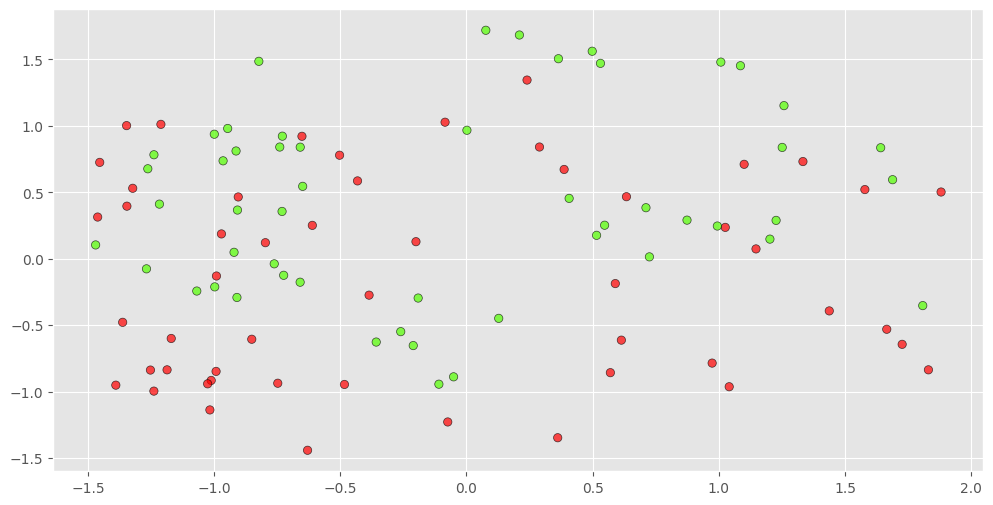

In [291]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
print(y_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9048991354466859
F1-score [0.9468599  0.54794521]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       325
           1       0.39      0.91      0.55        22

    accuracy                           0.90       347
   macro avg       0.69      0.91      0.75       347
weighted avg       0.96      0.90      0.92       347



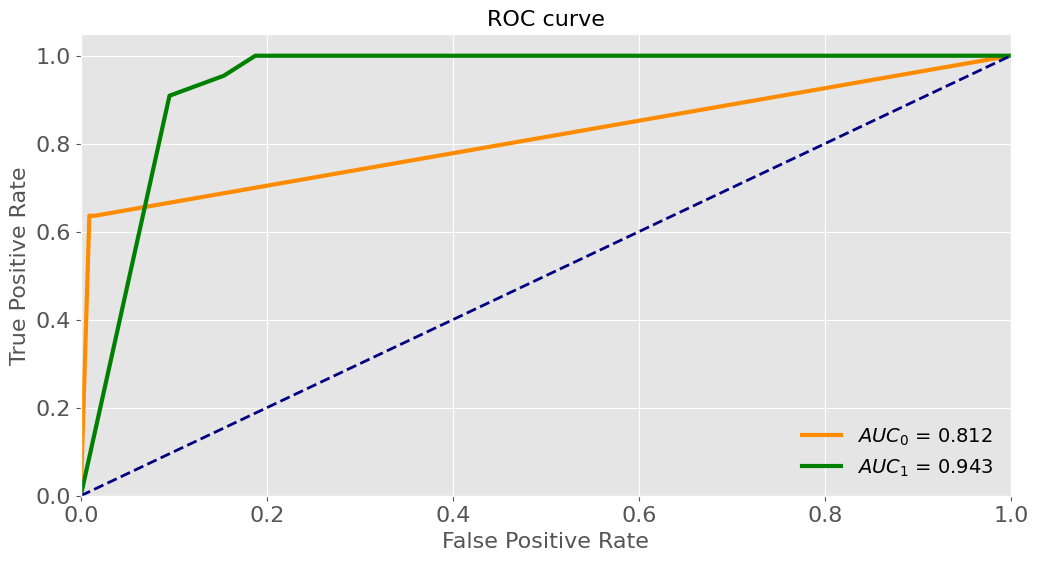

In [292]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [293]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 114, 1: 52})


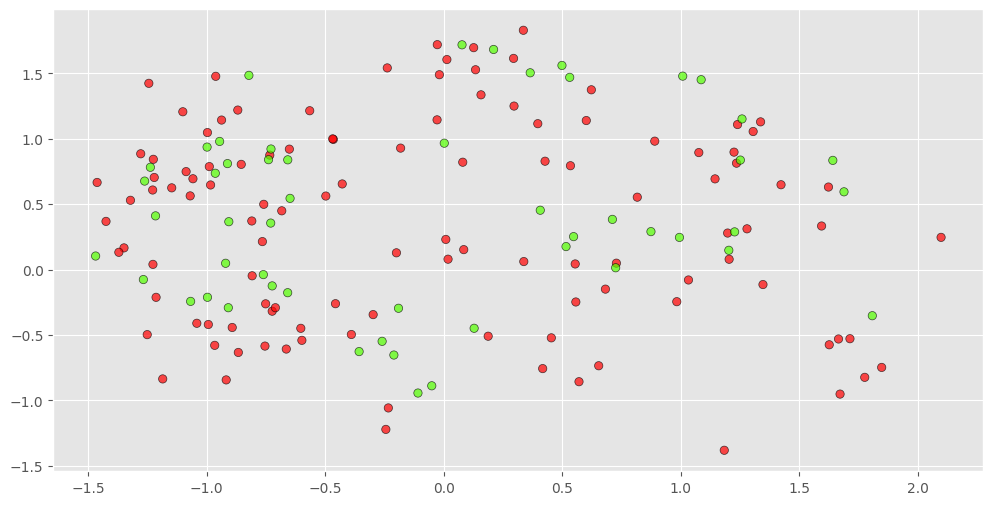

In [294]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.968299711815562
F1-score [0.98305085 0.75555556]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       325
           1       0.74      0.77      0.76        22

    accuracy                           0.97       347
   macro avg       0.86      0.88      0.87       347
weighted avg       0.97      0.97      0.97       347



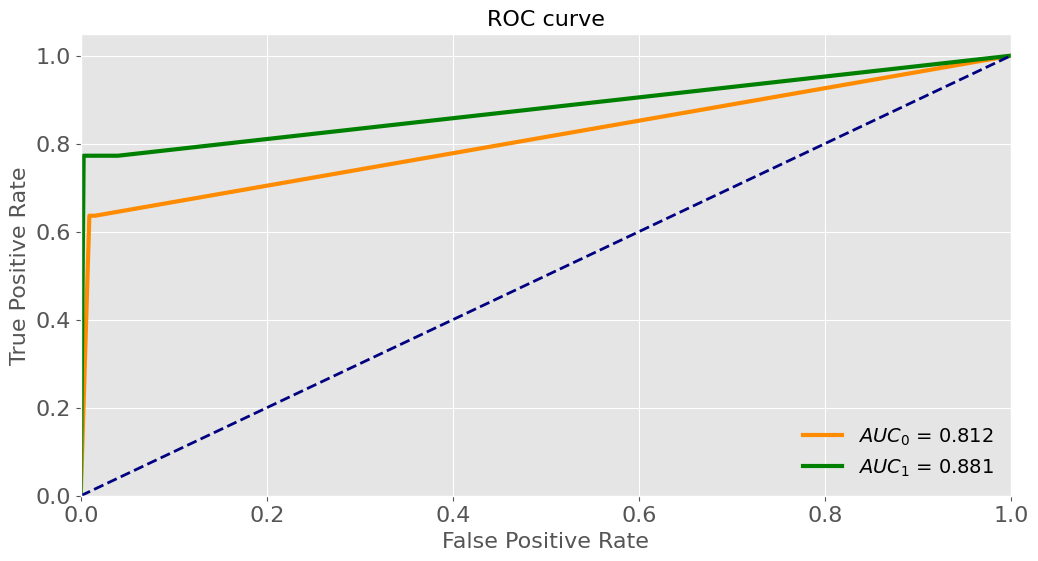

In [295]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Tomek Links

In [296]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 745, 1: 52})


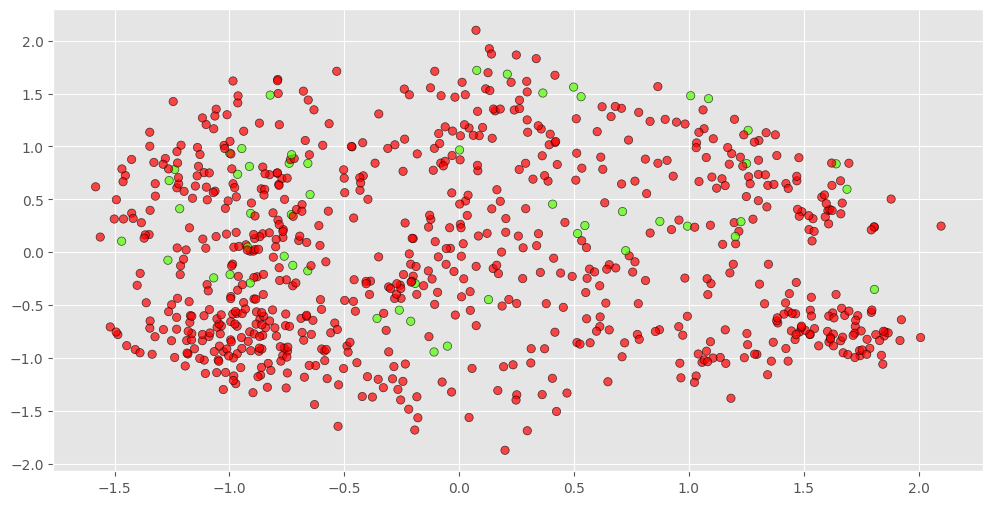

In [297]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)


plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9798270893371758
F1-score [0.98931298 0.82051282]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       325
           1       0.94      0.73      0.82        22

    accuracy                           0.98       347
   macro avg       0.96      0.86      0.90       347
weighted avg       0.98      0.98      0.98       347



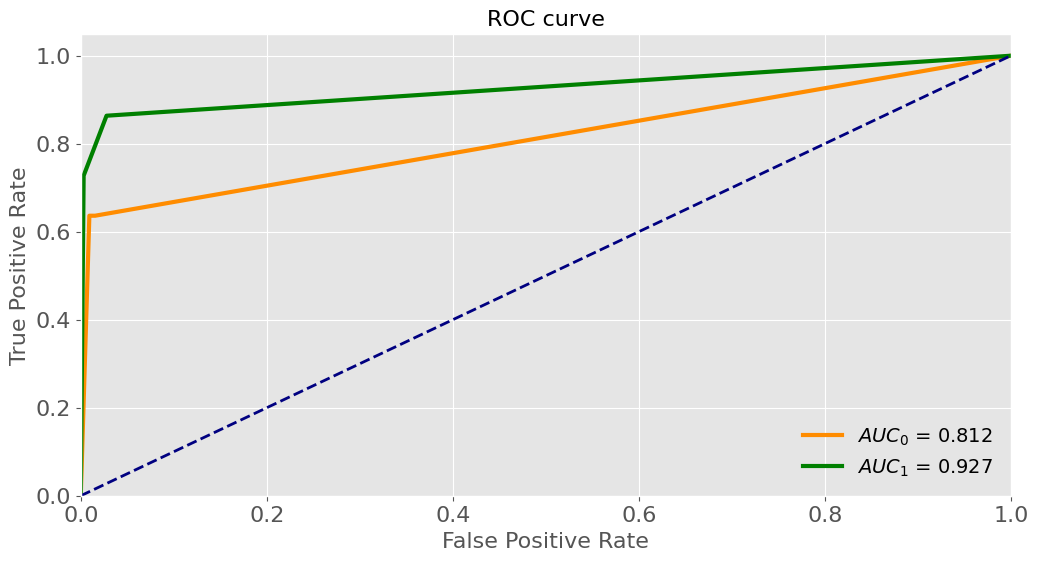

In [298]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Edited Nearest Neighbors

In [299]:
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 694, 1: 52})


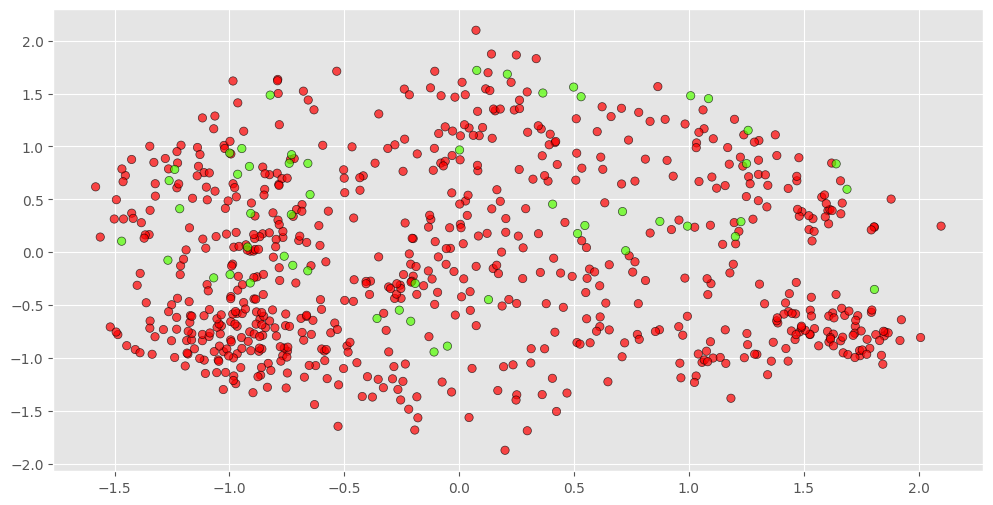

In [300]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9827089337175793
F1-score [0.99076923 0.86363636]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       325
           1       0.86      0.86      0.86        22

    accuracy                           0.98       347
   macro avg       0.93      0.93      0.93       347
weighted avg       0.98      0.98      0.98       347



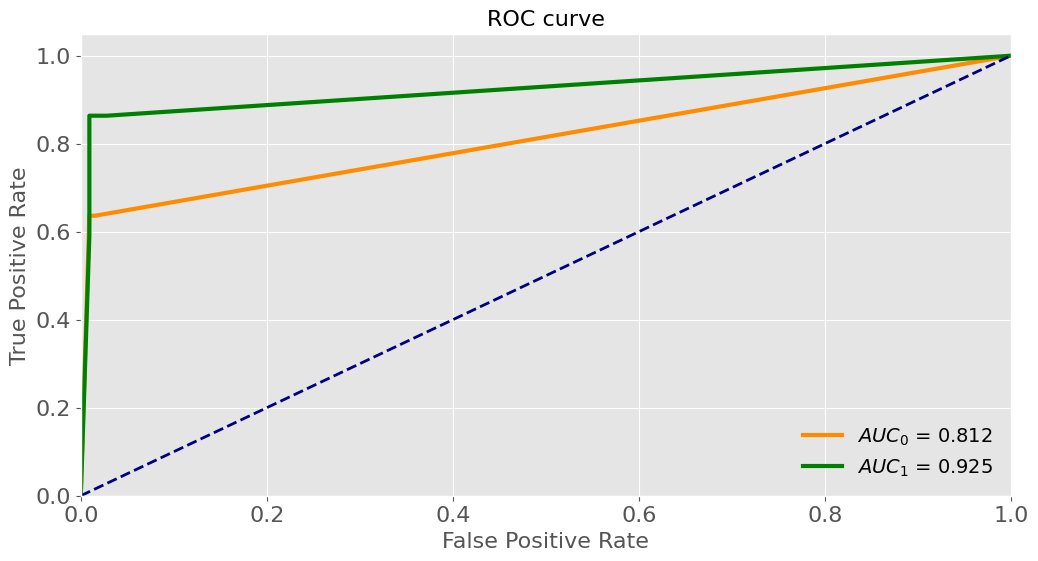

In [301]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Cluster Centroids

In [302]:
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids

In [303]:
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42
)
X_res, y_res = cc.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 74, 1: 74})


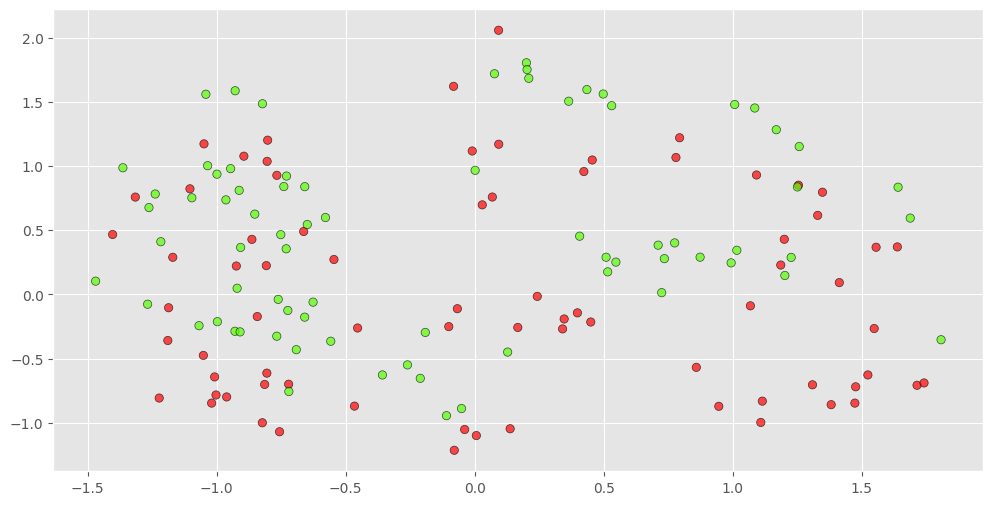

In [304]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9164265129682997
F1-score [0.95345104 0.5915493 ]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       325
           1       0.43      0.95      0.59        22

    accuracy                           0.92       347
   macro avg       0.71      0.93      0.77       347
weighted avg       0.96      0.92      0.93       347



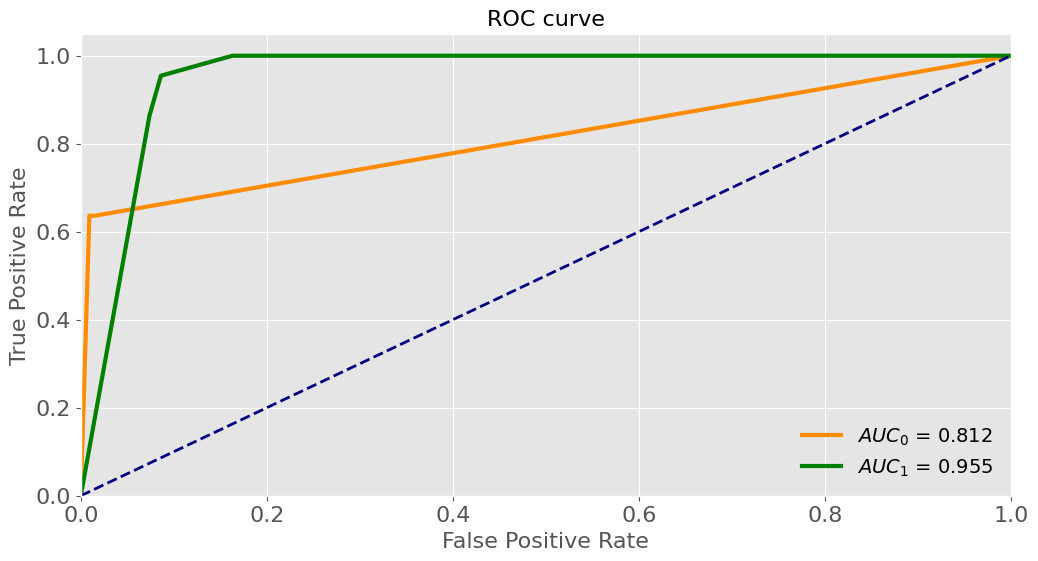

In [305]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#OverSampling

### RandomOverSampler

In [306]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [307]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 755, 1: 755})


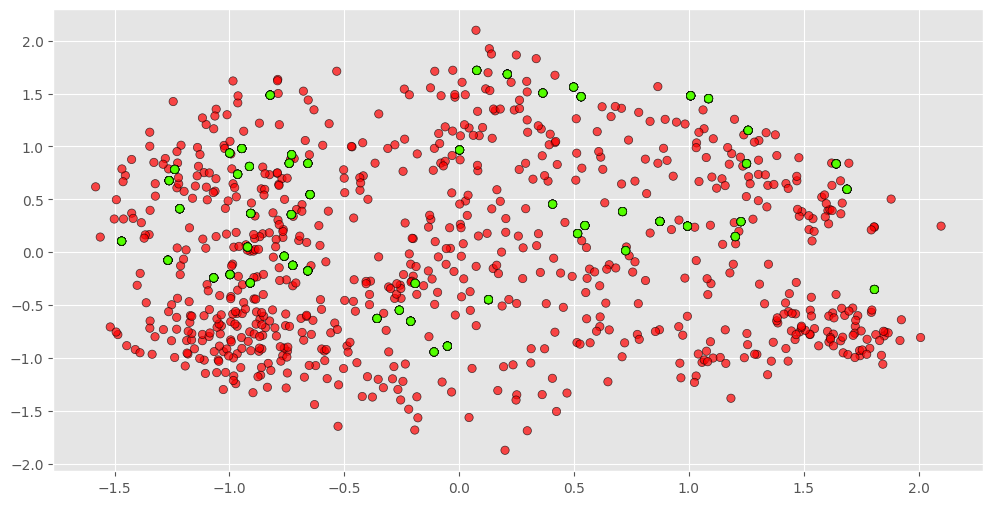

In [308]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9740634005763689
F1-score [0.98625954 0.76923077]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       325
           1       0.88      0.68      0.77        22

    accuracy                           0.97       347
   macro avg       0.93      0.84      0.88       347
weighted avg       0.97      0.97      0.97       347



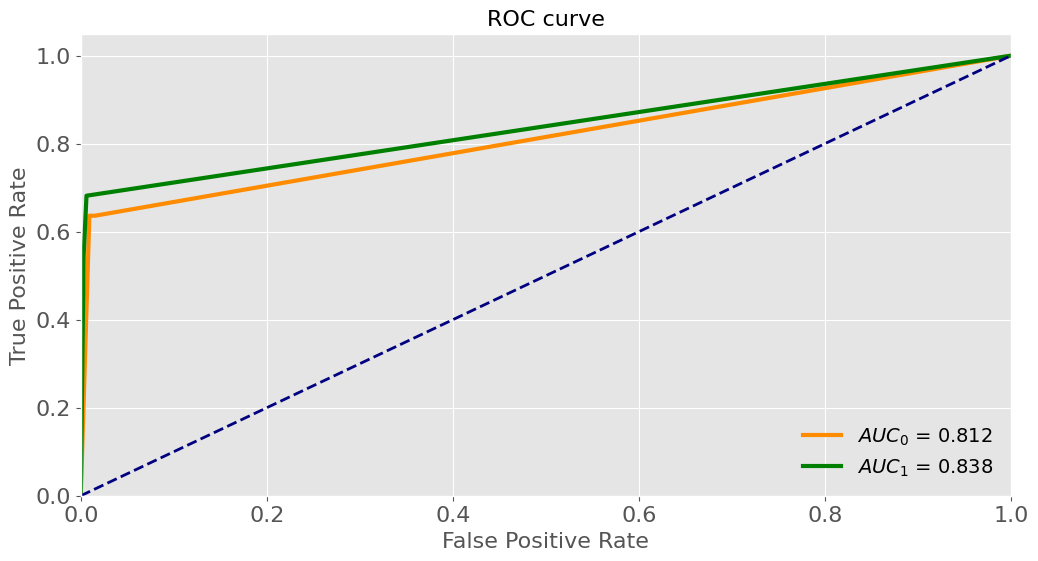

In [309]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

###SMOTE

In [310]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 755, 1: 755})


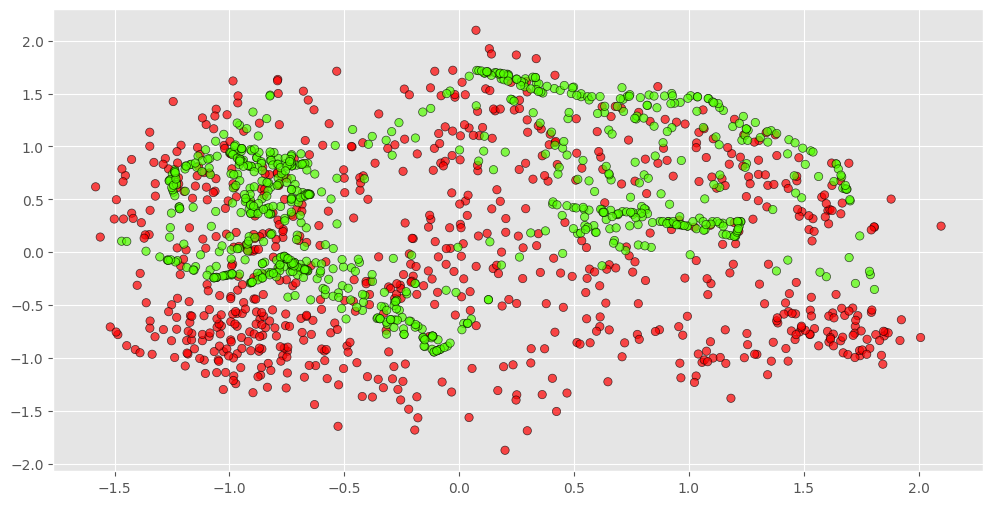

In [311]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9711815561959655
F1-score [0.9845679 0.7826087]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       325
           1       0.75      0.82      0.78        22

    accuracy                           0.97       347
   macro avg       0.87      0.90      0.88       347
weighted avg       0.97      0.97      0.97       347



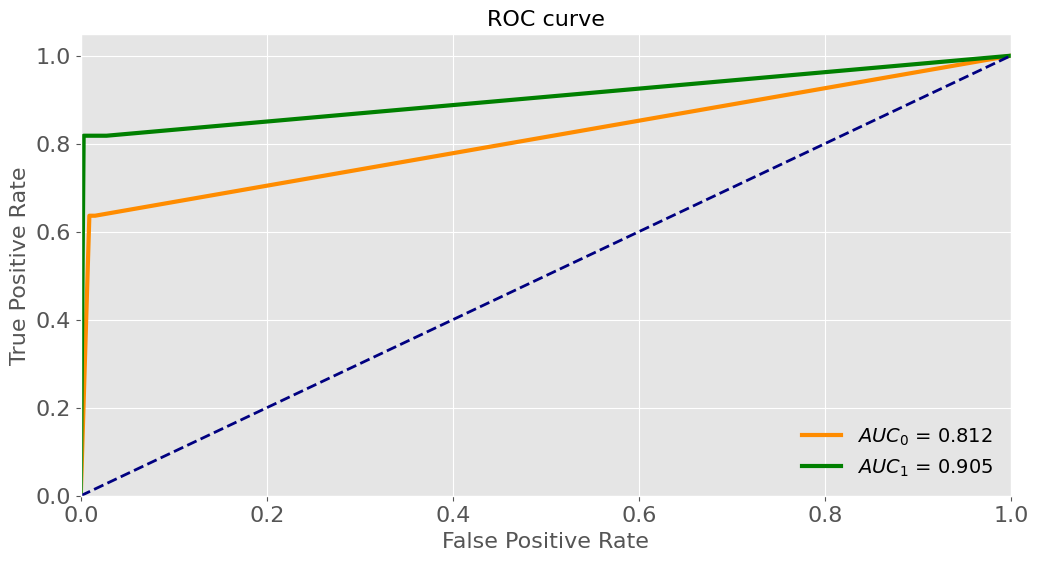

In [312]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

###ADASYN

In [313]:
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1080, 1: 1079})


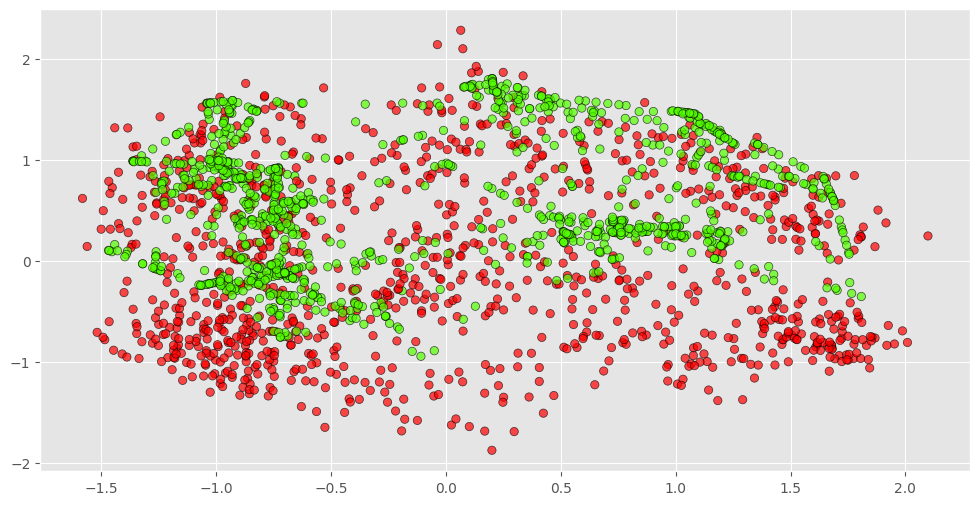

In [314]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9971181556195965
F1-score [0.9984639  0.97674419]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       325
           1       1.00      0.95      0.98        22

    accuracy                           1.00       347
   macro avg       1.00      0.98      0.99       347
weighted avg       1.00      1.00      1.00       347



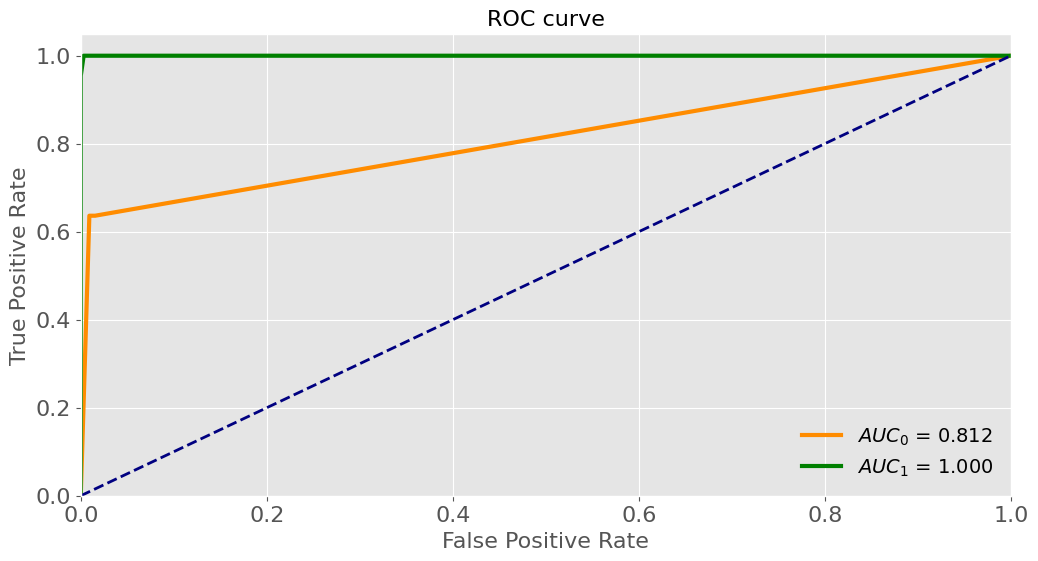

In [315]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()